In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
%load_ext tensorboard
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from pprint import pprint
from collections import defaultdict
import pandas as pd
import numpy as np
from nltk.tokenize import regexp_tokenize
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
df = pd.read_csv('New_Delhi_reviews.csv', sep=',')

In [2]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [3]:
tf.__version__

'2.11.0'

In [4]:
df.shape

(12495, 12)

In [5]:
# add columns to df w/ word and character counts
df['total words'] = [len(x.split()) for x in df['content'].tolist()]
df['total chars'] = df['content'].apply(len)
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,total words,total chars
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo,6,29
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo,19,89
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo,36,200
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo,44,227
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo,4,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,gp:AOqpTOEQPqib7pb6vFyjMY9JEfsMs_u8WCdqg6mbcar...,Mildred Olima,https://play-lh.googleusercontent.com/a-/AOh14...,"I really like the planner, it helps me achieve...",5,0,4.5.4,2018-12-21 00:13:09,NaN,NaN,newest,com.appxy.planner,24,122
12491,gp:AOqpTOE1KKOOVVKUfhAfXQs2NfJpoywfucrJCMK3Hmu...,Roaring Grizzly Bear,https://play-lh.googleusercontent.com/a-/AOh14...,😁****😁,5,0,NaN,2018-12-12 21:52:56,NaN,NaN,newest,com.appxy.planner,1,6
12492,gp:AOqpTOFEn5UgYYggqiHKauDJVLLN8-16nk1AfZbEhkj...,amirbadang,https://play-lh.googleusercontent.com/-CM2FcrU...,Very useful apps. You must try it,5,0,4.5.4,2018-12-11 15:49:43,NaN,NaN,newest,com.appxy.planner,7,33
12493,gp:AOqpTOHOH6YdYLR91qZdYpeIVkMI-LeAE0EwYgrctid...,Emma Stebbins,https://play-lh.googleusercontent.com/-oCj6g6k...,Would pay for this if there were even more add...,5,0,4.5.4,2018-12-06 04:59:26,NaN,NaN,newest,com.appxy.planner,23,128


In [6]:
# count number of words with positive, neutral, and negative reviews
df['score'].value_counts()

5    2879
4    2775
1    2506
2    2344
3    1991
Name: score, dtype: int64

In [7]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
# Product Scores
fig = px.histogram(df, x="score")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Hotel rating')
fig.show()

In [8]:
# looking for null values
nan_in_df = df['content'].isnull().sum().any()
# Print the dataframe
print(nan_in_df)

False


In [9]:
df.dropna()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,total words,total chars
5,gp:AOqpTOEvElPsBa6k8rLDmk-WrEoJea98KUrIGYWodJe...,Jon Clemens,https://play-lh.googleusercontent.com/-q6L1fx0...,It has changed how I viewed my different lists...,1,1,5.6.0.7,2020-10-26 05:04:20,Please note that in order to sort the lists by...,2020-10-26 14:56:25,newest,com.anydo,22,111
6,gp:AOqpTOGHb-APKKMNFyL1OwuGq1AGW6bQp5aYYxSHvJx...,Gale W,https://play-lh.googleusercontent.com/a-/AOh14...,I'm only looking for a grocery list app but ev...,1,0,5.6.0.6,2020-10-25 23:40:46,Sorry about that. We are not aware of any issu...,2020-10-26 14:53:42,newest,com.anydo,101,476
7,gp:AOqpTOEcxvv_c0CK3G5tHjxXsGSjbzD65OQ3og02p-q...,No One,https://play-lh.googleusercontent.com/a-/AOh14...,"Reset my free trial, new phone I'd like to see...",1,0,5.5.0.8,2020-10-25 19:18:13,We have an extensive Help Center detailing how...,2020-10-26 14:43:36,newest,com.anydo,13,62
8,gp:AOqpTOHVgr7_qOhORsfPwnVCqX-n98dJ1Ksrps6q52p...,I Dewa Gede Nopi Ariana,https://play-lh.googleusercontent.com/a-/AOh14...,How do to stop monthly payment because i don't...,1,0,5.6.0.7,2020-10-25 10:09:00,Please note that you may cancel your subscript...,2020-10-26 14:39:59,newest,com.anydo,13,67
9,gp:AOqpTOHQ_paQ_ffWsMqGOWmMsPxs-pBkBgR_3H63WJv...,John Riddle,https://play-lh.googleusercontent.com/a-/AOh14...,I complain about not crashes and it was immedi...,1,1,5.6.0.7,2020-10-23 03:15:01,We are unaware of any issues with the app not ...,2020-10-25 17:11:06,newest,com.anydo,76,394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,gp:AOqpTOHJPGqKlHV-M7BUDJmy5IPrW0suxfZNusvris4...,Steve Peach,https://play-lh.googleusercontent.com/a-/AOh14...,Suddenly need a subscription? After I had pai...,2,21,4.1.1,2016-07-18 02:26:59,"Dear Steven, please contact us at planner.a@ap...",2016-07-18 16:19:35,newest,com.appxy.planner,25,139
11945,gp:AOqpTOHv08qhcs9_pgDUZkWToG28to-lhf1REWer2Ht...,steven Ulewicz,https://play-lh.googleusercontent.com/-N1_Dwn2...,Can't load past notes it does work sometimes b...,3,0,5.0.7,2020-10-24 17:43:53,"Hi, would you please contact us at planner.a@a...",2020-10-26 10:57:10,newest,com.appxy.planner,19,89
11949,gp:AOqpTOEBPybXpCNsipTLiUwE5POZzA-Zq7Ko-aEA5WQ...,Dustin Hamilton,https://play-lh.googleusercontent.com/-iPCictM...,I like this app but sometimes it just closes a...,3,4,5.0.6,2020-09-28 17:23:18,"Hi, would you please contact us at planner.a@a...",2020-09-29 07:56:34,newest,com.appxy.planner,39,188
11950,gp:AOqpTOE3XpYixxVuyWdS5FwOvmKyLa7NnCPW4GmRNpq...,Bill Teele,https://play-lh.googleusercontent.com/-CYtj1_C...,Not bad. Wish it happens the option for more t...,3,0,5.0.6,2020-09-27 21:33:46,Thanks for your feedback. Would you please tel...,2020-09-29 07:56:05,newest,com.appxy.planner,12,59


In [10]:
# define punctuation and special characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]

In [11]:
# remove punc and special characters from content column
import warnings
warnings.filterwarnings("ignore")
for char in spec_chars:
    df['content'] = df['content'].str.replace(char, ' ')

In [12]:
# remove numbers from content column
df['content'] = df['content'].str.replace('\d+', '')

In [13]:
# making lowercase to reduce characters from 52 to 26. reduce input vector
df['content'] = df['content'].str.lower()

In [14]:
# tokenizing reviews or parsing sentences
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

df['review_tokenized'] = df['content'].apply(lambda x: tokenize(x))
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,total words,total chars,review_tokenized
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,i cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo,6,29,"[i, cannot, open, the, app, anymore]"
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,i have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo,19,89,"[i, have, been, begging, for, a, refund, from,..."
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,very costly for the premium version approx in...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo,36,200,"[very, costly, for, the, premium, version, app..."
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,used to keep me organized but all the update...,1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo,44,227,"[used, to, keep, me, organized, but, all, the,..."
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,dan birthday oct,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo,4,19,"[dan, birthday, oct, ]"


In [15]:
# stopwords to remove conjunctions, word particles quoted words
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(review_tokenized):
    text = [word for word in review_tokenized if word not in stopwords]
    return text

df['rev_noStopwords'] = df['review_tokenized'].apply(lambda x: remove_stopwords(x))
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,total words,total chars,review_tokenized,rev_noStopwords
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,i cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo,6,29,"[i, cannot, open, the, app, anymore]","[cannot, open, app, anymore]"
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,i have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo,19,89,"[i, have, been, begging, for, a, refund, from,...","[begging, refund, app, month, nobody, replying]"
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,very costly for the premium version approx in...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo,36,200,"[very, costly, for, the, premium, version, app...","[costly, premium, version, approx, indian, rup..."
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,used to keep me organized but all the update...,1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo,44,227,"[used, to, keep, me, organized, but, all, the,...","[used, keep, organized, updates, made, mess, t..."
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,dan birthday oct,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo,4,19,"[dan, birthday, oct, ]","[dan, birthday, oct, ]"


In [16]:
# lemmatize returns the whole word, stemming just the root
# lemmatization is more accurate truncates
from nltk.stem import WordNetLemmatizer # cleaning data
lemmatizer = WordNetLemmatizer()
def lem (token_text):
    text = [lemmatizer.lemmatize(word) for word in token_text]
    return text

In [17]:
# check lemmatization results and compare
df['content'].apply(lambda x: lem(x))
df['Lemmed_words'] = [len(x.split()) for x in df['content'].tolist()]
df['Lemmed_chars'] = df['content'].apply(len)
df.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,total words,total chars,review_tokenized,rev_noStopwords,Lemmed_words,Lemmed_chars
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,i cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo,6,29,"[i, cannot, open, the, app, anymore]","[cannot, open, app, anymore]",6,29
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,i have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo,19,89,"[i, have, been, begging, for, a, refund, from,...","[begging, refund, app, month, nobody, replying]",19,89
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,very costly for the premium version approx in...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo,36,200,"[very, costly, for, the, premium, version, app...","[costly, premium, version, approx, indian, rup...",35,197
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,used to keep me organized but all the update...,1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo,44,227,"[used, to, keep, me, organized, but, all, the,...","[used, keep, organized, updates, made, mess, t...",41,223
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,dan birthday oct,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo,4,19,"[dan, birthday, oct, ]","[dan, birthday, oct, ]",3,17


In [18]:
# maximum, average, and median sequence length
from statistics import mean
from statistics import median
Max_sentence_length = max([len(x)for x in df['content']])
print('Maximum sequence length: ', Max_sentence_length)
Avg_sentence_length = mean([len(x)for x in df['content']])
print('Average sequence length: ', Avg_sentence_length)
Mdn_sentence_length = median([len(x)for x in df['content']])
print('Median sequence length: ', Mdn_sentence_length)

Maximum sequence length:  4073
Average sequence length:  147.33909563825532
Median sequence length:  97


In [19]:
# vectorize integer encoding
df['text_final'] = df['rev_noStopwords'].apply(lambda x: ' '.join(x))
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(df['text_final'])
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(12495, 11780)
['aa', 'aaa', 'aaah', 'aak', 'aap', 'aapako', 'aarach', 'aati', 'abandon', 'abandoned', 'abc', 'abd', 'abdon', 'abhor', 'abhorrent', 'abilities', 'ability', 'abitos', 'able', 'abosulely', 'abou', 'abound', 'abour', 'abraços', 'abre', 'abrir', 'abruptly', 'absence', 'absent', 'absolument', 'absolute', 'absolutely', 'absouletely', 'abstract', 'absurd', 'absurdly', 'abt', 'abuse', 'abusive', 'abutt', 'ac', 'acal', 'acalendar', 'acalender', 'acaltasks', 'acara', 'acc', 'accelerated', 'accept', 'acceptable', 'accepted', 'accepting', 'accepts', 'acces', 'accesible', 'access', 'accessed', 'accessibility', 'accessible', 'accessing', 'accessories', 'accessory', 'accesss', 'accident', 'accidental', 'accidentally', 'accidently', 'accomplish', 'accomplished', 'accomplishing', 'accomplishment', 'accomplishments', 'according', 'accordingly', 'account', 'accountability', 'accountable', 'accounts', 'accross', 'acct', 'accts', 'accually', 'accumulated', 'accuracy', 'accurate', 'accuratel

In [20]:
# after vectorizing there are 11780 words

# convert matrix into pandas dataframe given that tensorflow is unable to work with matrices
X_feat = pd.DataFrame(X_tfidf.toarray())
X_feat.head()
# dataframe inspection

,0,1,2,3,4,5,6,7,8,9,...,11770,11771,11772,11773,11774,11775,11776,11777,11778,11779
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# export the cleaned dataset
X_feat.to_csv('GooglePlayReviews_cleaned.csv')

In [22]:
# convert to a binary sentiment either positive or negative
# assign reviews with score > 3 as positive sentiment
# score <= 3 negative sentiment
df['score'] = df['score'].apply(lambda rating : +1 if rating > 3 else 0)

In [23]:
# count number of positive and negative reviews
df['score'].value_counts()

0    6841
1    5654
Name: score, dtype: int64

In [24]:
# 90 / 10 train test split
y_var = df.pop('score')
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_var, test_size=0.10, random_state=210)

In [25]:
# convert dataframe to tensor object 
# no need to pad sequences by converting vectorized list into a tensorflow data object
# vectorization function assigns a value, that value is contained in it's own cell in the tensor
# tensorflow will not be fed raw strings, therefore, no need to make strings length uniform, ergo there is no need for padding
print(df.shape); print(X_train.shape); print(X_test.shape)

(12495, 18)
(11245, 11780)
(1250, 11780)


In [26]:
dataset = tf.data.Dataset.from_tensor_slices((X_feat.values, y_var.values))

In [27]:
train_dataset = dataset.shuffle(len(df)).batch(1)

In [1]:
# nodes calculation and output
import math
est_emb = math.sqrt(11780)
est_emb

108.53570840972108

In [29]:
# define / build model
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [30]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
# fit model to the training dataset
model = get_compiled_model()
history = model.fit(train_dataset, epochs=5, callbacks=[tensorboard_callback])
model.summary()

Epoch 1/5
12495/12495 [==============================] - 268s 21ms/step - loss: 0.4523 - accuracy: 0.7822
Epoch 2/5
12495/12495 [==============================] - 261s 21ms/step - loss: 0.3274 - accuracy: 0.8595
Epoch 3/5
12495/12495 [==============================] - 255s 20ms/step - loss: 0.2577 - accuracy: 0.8984
Epoch 4/5
12495/12495 [==============================] - 238s 19ms/step - loss: 0.1905 - accuracy: 0.9269
Epoch 5/5
12495/12495 [==============================] - 256s 20ms/step - loss: 0.1349 - accuracy: 0.9490
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1178100   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                

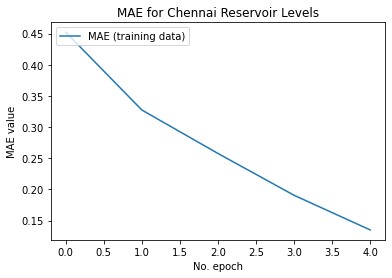

In [32]:
plt.plot(history.history['loss'], label='MAE (training data)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [33]:
# early stopping to prevent overfitting
tf.debugging.disable_traceback_filtering()
early_stopping_monitor = EarlyStopping(patience=2)
history = model.fit(X_train, y_train,epochs = 5, batch_size = 32,
                    validation_data=(X_test, y_test))

Epoch 1/5
352/352 [==============================] - 13s 33ms/step - loss: 0.0920 - accuracy: 0.9634 - val_loss: 0.0954 - val_accuracy: 0.9624
Epoch 2/5
352/352 [==============================] - 11s 31ms/step - loss: 0.0793 - accuracy: 0.9693 - val_loss: 0.0947 - val_accuracy: 0.9624
Epoch 3/5
352/352 [==============================] - 9s 27ms/step - loss: 0.0725 - accuracy: 0.9722 - val_loss: 0.0945 - val_accuracy: 0.9616
Epoch 4/5
352/352 [==============================] - 10s 30ms/step - loss: 0.0671 - accuracy: 0.9738 - val_loss: 0.0945 - val_accuracy: 0.9616
Epoch 5/5
352/352 [==============================] - 11s 32ms/step - loss: 0.0623 - accuracy: 0.9763 - val_loss: 0.0956 - val_accuracy: 0.9608


In [34]:
history.history

{'loss': [0.09203431755304337,
  0.07934894412755966,
  0.07245782017707825,
  0.06705289334058762,
  0.06232224032282829],
 'accuracy': [0.9633615016937256,
  0.9693197011947632,
  0.9721654057502747,
  0.9737660884857178,
  0.9763450622558594],
 'val_loss': [0.0954258069396019,
  0.0947154089808464,
  0.09446297585964203,
  0.09445914626121521,
  0.09556837379932404],
 'val_accuracy': [0.9624000191688538,
  0.9624000191688538,
  0.9616000056266785,
  0.9616000056266785,
  0.9607999920845032]}

In [35]:
# plot training and validation scores
def plot_learningCurve(history, epochs):
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

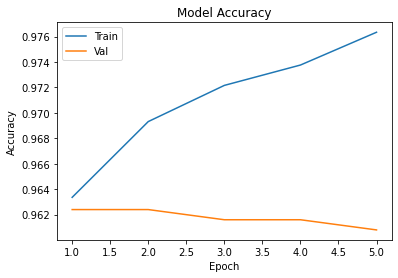

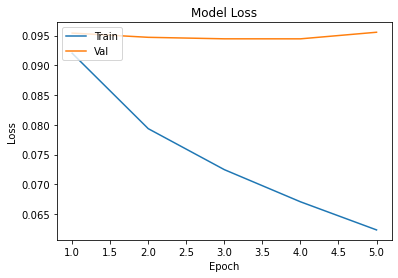

In [36]:
plot_learningCurve(history, 5)

In [37]:
# model evaluation against the test dataset
model.evaluate(X_test, y_test)

40/40 [==============================] - 0s 6ms/step - loss: 0.0956 - accuracy: 0.9608


[0.09556837379932404, 0.9607999920845032]

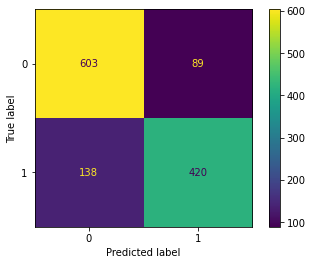

In [40]:
# create confusion matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [41]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[603, 138],
       [ 89, 420]], dtype=int64)

In [42]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       741
           1       0.75      0.83      0.79       509

    accuracy                           0.82      1250
   macro avg       0.81      0.82      0.81      1250
weighted avg       0.82      0.82      0.82      1250



In [43]:
# confusion matrix manual accuracy corroboration
# CMaccuracy = (True positive+True negative)/(Tp+Tn+False positive+False negative)
CMaccuracy = (112+116)/(112+116+29+18)
CMaccuracy

0.8290909090909091

In [44]:
# saving the model
model.save("Trained_Model_GooglePlayReviews.keras")